# ME 595r - Autonomous Sytems
# Extended Kalman Filter

## Dynamic Model
This filter will estimate the states of a ground robot with velocity inputs and a sensor that measures range and bearing to landmarks. The state is parameterized as
$$ x = \begin{bmatrix}x \\ y \\ \theta \end{bmatrix} $$

The commanded input is

$$ \hat{u} = \begin{bmatrix} \hat{v} \\ \hat{\omega} \end{bmatrix} $$

The true input to the system is equal to the commanded input corrupted by noise

$$ u = \hat{u} + \xi_u $$

Where $ \xi_u $ is a zero-mean multivariate random variable with covariance

$$ \Sigma_{\xi_u} = \begin{bmatrix} \alpha_1 v_t^2 + \alpha_2 \omega_t^2 & 0 \\ 0 & \alpha_3 v_t^2 + \alpha_4 \omega_t^2 \end{bmatrix} $$

The state evolves as

$$ \bar{x}_t = f(x, u) = x_{t-1} + 
\begin{bmatrix} 
-\tfrac{v_t}{\omega_t}\sin(\theta_{t-1}) + \tfrac{v_t}{\omega_t}\sin(\theta_{t-1} + \omega_t \Delta t) \\
\tfrac{v_t}{\omega_t}\cos(\theta_{t-1}) - \tfrac{v_t}{\omega_t}\cos(\theta_{t-1} + \omega_t \Delta t) \\
\omega_t \Delta t
\end{bmatrix} $$

For the Extended Kalman filter, we need to linearize the dynamic model about our state and our input

$$ A_d = \frac{\partial f}{\partial x} = 
\begin{bmatrix}
1 & 0 & -\tfrac{v_t}{\omega_t}\cos(\theta_{t-1}) + \tfrac{v_t}{\omega_t}\cos(\theta_{t-1} + \omega_t \Delta t) \\
0 & 1 & -\tfrac{v_t}{\omega_t}\sin(\theta_{t-1}) + \tfrac{v_t}{\omega_t}\sin(\theta_{t-1} + \omega_t \Delta t) \\
0 & 0 & 1
\end{bmatrix} $$

## Measurements and Noise
We will measure the range and bearing to landmarks

## Implementation

In [1]:
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from tqdm import tqdm
#import plotly.plotly as pl
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
figWidth = 11
figHeight = 8

In [2]:
def wrap_each(x):
    for i, y in enumerate(x):
        x[i] = wrap(y)
        return x
        
def wrap(x):
    while x < -np.pi:
        x += 2*np.pi
    while x > np.pi:
        x -= 2*np.pi
    return x

class EKF_SLAM(object):
    def __init__(self, x0, input_dim, num_landmarks, f, g, del_f_x, del_g_x, R, P, Ts, Q=None, del_f_u=None, Qu=None):
        self.f = f
        self.g = g
        self.del_f_x = del_f_x
        self.del_g_x = del_g_x
        self.n = len(x0)  # state dimension
        self.m = input_dim  # input dimension
        self.l = num_landmarks
        if del_f_u is not None:
            self.del_f_u = del_f_u
        else:
            self.del_f_u = lambda x, u: np.zeros((self.n, self.m))
        if Qu is not None:
            self.Qu = Qu
        else:
            self.Qu = lambda u: np.zeros((self.m, self.m))
        if Q is not None:
            self.Q = Q
        else:
            self.Q = np.zeros((self.n, self.n))
        self.R = R
        self.x = np.concatenate((x0, np.zeros(2*num_landmarks)))
        P_upper = np.hstack((P, np.zeros((self.n, 2*num_landmarks))))
        P_lower = np.hstack((np.zeros((2*num_landmarks, self.n)), 1e10*np.eye(2*num_landmarks)))
        self.P = np.vstack((P_upper, P_lower))
        self.Ts = Ts

    def predict(self,u):
#         print(u)
#         print(self.x)
#         print(A.dot(self.x).reshape(2,1))
#         print(self.B.dot(u))
        #self.x = self.A.dot(self.x).reshape(2,1) + self.B.dot(u)
#         print(self.x[:3, 0].shape)
#         print(self.f(self.x[:3, 0], u, Ts).shape)
        self.x[:3] = self.f(self.x[:3], u, Ts)
        A = self.del_f_x(self.x[:3], u, Ts)
        B = self.del_f_u(self.x[:3], u, Ts)
#         F = np.eye(self.n, self.n + 2*self.l)
#         A_aug = np.eye(self.n + 2*self.l) + F.T.dot(A).dot(F)
#         self.P = A_aug.dot(self.P).dot(A_aug.T) + F.T.dot(B).dot(self.Qu(u)).dot(B.T).dot(F)
        A = np.eye(self.n) + A
        self.P[:3, :3] = A.dot(self.P[:3, :3]).dot(A.T) + B.dot(self.Qu(u)).dot(B.T) + self.Q
        
    def update(self, z, landmark_idx):
        #from IPython.core.debugger import Tracer; Tracer()()
        idx = 3+2*landmark_idx
        if self.x[idx] == 0.:
            self.x[idx:idx+2] = self.x[:2] + np.array([z[0]*np.cos(z[1] + self.x[2]), 
                                                       z[0]*np.sin(z[1] + self.x[2])])
        landmark = self.x[idx:idx+2]
        F = np.hstack((np.eye(5, 3), 
                       np.zeros((5, 2*landmark_idx)), 
                       np.vstack((np.zeros((3, 2)), np.eye(2))), 
                       np.zeros((5, 2*(self.l-1) - 2*landmark_idx))))
        
        C = self.del_g_x(self.x, landmark)
        C_aug = C.dot(F)
#         print(C_aug)
        S = C_aug.dot(self.P.dot(C_aug.T)) + self.R
#         print(C_aug)
        self.K = self.P.dot(C_aug.T).dot(np.linalg.inv(S))
        res = z - self.g(self.x, landmark)
        res[1] = wrap(res[1])
        self.x = self.x + self.K.dot(res)
        self.P = (np.eye(self.n + 2*self.l) - self.K.dot(C_aug)).dot(self.P)
#         print(self.P[:2, :2])

In [4]:
# initialize inputs and state truth

Ts = 0.1
Tend = 30

t = np.arange(start=Ts, stop=Tend+Ts, step = Ts)

alpha = np.array([0.1, 0.01, 0.01, 0.1])

v_c = 1 + 0.5*np.cos(2*np.pi*0.2*t)
omega_c = -0.2 + 2*np.cos(2*np.pi*0.6*t)

v = v_c + np.random.normal(0, alpha[0]*np.square(v_c) + alpha[1]*np.square(omega_c))
omega = omega_c + np.random.normal(0, alpha[2]*np.square(v_c) + alpha[3]*np.square(omega_c))

u_c = np.vstack((v_c, omega_c))
u = np.vstack((v, omega))
# print(u.shape)
x = np.zeros((3, len(t)))
# x[:, 0] = np.array([-5, -3, np.pi/2])
x[:, 0] = np.array([0, 0, 0])

#landmarks = np.array([[6, -7, 6], [4, 8, -4]])

# num_landmarks = 40
# np.random.seed(4)
num_landmarks = 50
np.random.seed(5)
landmarks = np.random.uniform(low=-10., high=10., size=(2, num_landmarks))


# # define the model
# def f(x, u, dt):
#     v = u.flatten()[0]
#     w = u.flatten()[1]
#     theta = x.flatten()[2]
#     dx = np.array([-v/w*np.sin(theta) + v/w*np.sin(theta + w*dt),
#                          v/w*np.cos(theta) - v/w*np.cos(theta + w*dt),
#                          w*dt])
#     x_next = x.flatten() + dx
#     #print(x_next)
#     return x_next

# define the model
def f(x, u, dt):
    v = u[0]
    w = u[1]
    theta = x[2]
    dx = np.array([-v/w*np.sin(theta) + v/w*np.sin(theta + w*dt),
                   v/w*np.cos(theta) - v/w*np.cos(theta + w*dt),
                   w*dt])
#     print(dx.shape)
    x_next = x + dx
    #print(x_next)
    return x_next

def del_f_x(x, u, dt):
    v = u.flatten()[0]
    w = u.flatten()[1]
    theta = x.flatten()[2]
    A = np.array([[0, 0, v/w*(-np.cos(theta) + np.cos(theta + w*dt))],
                  [0, 0, v/w*(-np.sin(theta) + np.sin(theta + w*dt))],
                  [0, 0, 0]])
    return A

def del_f_u(x, u, dt):
    v = u.flatten()[0]
    w = u.flatten()[1]
    theta = x.flatten()[2]
    B = np.array([[1/w*(-np.sin(theta) + np.sin(theta + w*dt)), 
                       v/w*(1/w*(np.sin(theta) - np.sin(theta + w*dt)) + np.cos(theta + w*dt)*dt)],
                  [1/w*(np.cos(theta) - np.cos(theta + w*dt)), 
                       v/w*(-1/w*(np.cos(theta) - np.cos(theta + w*dt)) + np.sin(theta + w*dt)*dt)],
                  [0, dt]])
    return B



def g(x, landmark):
    q = (landmark[0] - x[0])**2 + (landmark[1] - x[1])**2
    theta = np.arctan2(landmark[1] - x[1], landmark[0] - x[0]) - x[2]
    return np.array([np.sqrt(q),
                     wrap(theta)])

def del_g_x(x, landmark):
    lx = landmark[0]
    ly = landmark[1]
    dx = lx - x[0]
    dy = ly - x[1]
    q = (dx)**2 + (dy)**2
    sq = np.sqrt(q)
    C = np.array([[-dx/sq, -dy/sq, 0., dx/sq, dy/sq],
                  [dy/q,   -dx/q, -1., -dy/q, dx/q]])
#     Ca = np.copy(C)
#     # try numeric differentiation
#     delta = 0.0000001
#     for i in xrange(len(x)):
#         C[:, i] = (g(x + delta*np.eye(1, len(x), i).flatten(), landmark) - g(x, landmark))/delta
#     print(C - Ca)
    return C

def Qu(u):
    v = u[0]
    w = u[1]
    return np.array([[alpha[0]*v**2 + alpha[1]*w**2, 0],
                     [0, alpha[2]*v**2 + alpha[3]*w**2]])

sigma_r = 0.1
sigma_phi = 0.05
R = np.array([[sigma_r**2, 0],
              [0, sigma_phi**2]])

# P = np.array([[1, 0, 0],
#               [0, 1, 0],
#               [0, 0, 0.1]])
P = np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 0]])

# for landmark in landmarks.T:
#     print(landmark)

# generate truth data
for i in tqdm(xrange(1, len(t)), desc="Generating Truth", ncols=110):
    x[:, i:i+1] = f(x[:, i-1:i], u[:, i:i+1], Ts)

    
xHat = np.zeros_like(x)
xHat[:, 0] = x[:, 0]
sig = np.zeros_like(x)
sig[:, 0] = np.sqrt(P.diagonal())
landmark_P = np.zeros((2, 2, num_landmarks, len(t)))
K = np.zeros((3, 2, len(t)-1))
landmarksHat = np.zeros((2, num_landmarks, len(t)))
input_dim = u.shape[0]
ekf = EKF_SLAM(xHat[:, 0], input_dim, num_landmarks, f, g, del_f_x, del_g_x, R, P, Ts, del_f_u=del_f_u, Qu=Qu)

zHat = np.zeros((2, len(t)))

for i in tqdm(xrange(1, len(t)), desc="Estimating", ncols=110):
    uHat = u[:, i] + np.random.multivariate_normal([0, 0], Qu(u[:, i]))
    ekf.predict(uHat)
    for j, landmark in enumerate(landmarks.T):
        z = g(x[:, i], landmark) + np.random.multivariate_normal([0, 0], R)
        z[1] = wrap(z[1])
        if abs(z[1]) < np.pi/4:
#             zHat[:, i] = z
            ekf.update(z, j)
#     landmark = landmarks[:, 0]
#     z = g(x[:, i], landmark) + np.random.multivariate_normal([0, 0], R)
#     ekf.update(z, landmark)
    xHat[:, i] = ekf.x[:3]
#     K[:, :, i-1] = ekf.K
    sig[:, i] = np.sqrt(ekf.P.diagonal()[:3])
    
    for j in xrange(num_landmarks):
        landmarksHat[:, j, i] = ekf.x[3+2*j:5+2*j]
        idx = 3+2*j
        landmark_P[:, :, j, i] = ekf.P[idx:idx+2, idx:idx+2]
# e = np.sqrt(((x[0, :] - xHat[0, :])**2 + (x[1, :] - xHat[1, :])**2))

# print("Error norm = {}".format(np.linalg.norm(e)))
    


Estimating: 100%|███████████████████████████████████████████████████████████| 299/299 [00:09<00:00, 30.64it/s]


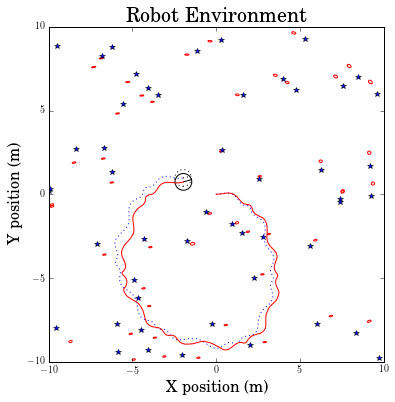

In [5]:
from matplotlib.patches import Ellipse

def plot_ellipse(loc, P):
    U, s, _ = np.linalg.svd(P)
    s = np.sqrt(5.991)*np.sqrt(s)
    alpha = np.arctan2(U[1, 0], U[0, 0])
    ellipse = Ellipse(loc, s[0], s[1], alpha*180/np.pi, ec='r', fill=False)
    return ellipse

def update_ellipse(ellipse, loc, P):
    U, s, _ = np.linalg.svd(P)
    s = np.sqrt(5.991)*np.sqrt(s)
    alpha = np.arctan2(U[1, 0], U[0, 0])
    ellipse.center = loc
    ellipse.width = s[0]
    ellipse.height = s[1]
    ellipse.angle = alpha*180/np.pi


plt.close('all')
env = plt.figure(figsize=(6, 6))
ax = env.add_subplot(1, 1, 1)
ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))
ax.set_title("Robot Environment",fontsize=20)
ax.set_xlabel("X position (m)", fontsize=16)
ax.set_ylabel("Y position (m)", fontsize=16)

robot = plt.Circle((x[0, -1], x[1, -1]), 0.5, fill=False, linestyle=":")
robotHat = plt.Circle((xHat[0, -1], xHat[1, -1]), 0.5, fill=False)
ax.add_artist(robot)
ax.add_artist(robotHat)
direction = np.array([[0, np.cos(x[2, -1])], [0, np.sin(x[2, -1])]])/2
line, = ax.plot(x[0, -1] + direction[0, :], x[1, -1] + direction[1, :], 'k:')
directionHat = np.array([[0, np.cos(xHat[2, -1])], [0, np.sin(xHat[2, -1])]])/2
lineHat, = ax.plot(xHat[0, -1] + directionHat[0, :], xHat[1, -1] + directionHat[1, :], 'k')
features, = ax.plot(landmarks[0, :], landmarks[1, :], 'b*', markersize=6)
# featuresHat, = ax.plot(landmarksHat[0, :, -1], landmarksHat[1, :, -1], 'r*', markersize=10)
ellipses = []
for j in xrange(num_landmarks):
    ell = plot_ellipse(landmarksHat[:, j, -1], landmark_P[:, :, j, -1])
    ax.add_artist(ell)
    ellipses.append(ell)
truth, = ax.plot(x[0, :], x[1, :], 'b:')
estimate, = ax.plot(xHat[0, :], xHat[1, :], 'r')
plt.show()


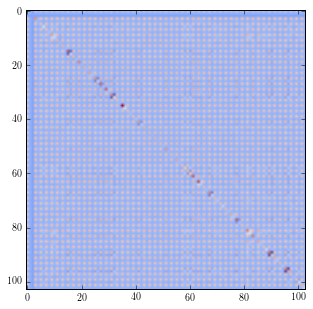

-0.00334790926044
0.0120072186129


In [9]:
plt.figure(figsize=(5, 5))
m_handle = plt.imshow(ekf.P, cmap="coolwarm")
# m_handle.norm.vmin = -0.004
# m_handle.norm.vmax = 0.02
plt.show()
print(np.min(ekf.P))
print(np.max(ekf.P))

In [7]:
plt.close('all')
env = plt.figure(figsize=(6, 6))
ax = env.add_subplot(1, 1, 1)
ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))
ax.set_title("Robot Environment",fontsize=20)
ax.set_xlabel("X position (m)", fontsize=16)
ax.set_ylabel("Y position (m)", fontsize=16)

robot = plt.Circle((x[0, 0], x[1, 0]), 0.5, fill=False, linestyle=":")
robotHat = plt.Circle((xHat[0, 0], xHat[1, 0]), 0.5, fill=False)
ax.add_artist(robot)
ax.add_artist(robotHat)
direction = np.array([[0, np.cos(x[2, 0])], [0, np.sin(x[2, 0])]])/2
line, = ax.plot(x[0, 0] + direction[0, :], x[1, 0] + direction[1, :], 'k:')
directionHat = np.array([[0, np.cos(xHat[2, 0])], [0, np.sin(xHat[2, 0])]])/2
lineHat, = ax.plot(xHat[0, 0] + directionHat[0, :], xHat[1, 0] + directionHat[1, :], 'k')
features, = ax.plot(landmarks[0, :], landmarks[1, :], 'b*', markersize=5)
# featuresHat, = ax.plot(landmarksHat[0, :, 0], landmarksHat[1, :, 0], 'r*', markersize=5)
ellipses = []
for j in xrange(num_landmarks):
    ell = plot_ellipse(landmarksHat[:, j, 0], landmark_P[:, :, j, 0])
    ax.add_artist(ell)
    ellipses.append(ell)
truth, = ax.plot(x[0, 0], x[1, 0], 'b:')
estimate, = ax.plot(xHat[0, 0], xHat[1, 0], 'r')

# cart = np.array([zHat[0, 0]*np.cos(zHat[1, 0]+xHat[2, 0]), zHat[0, 0]*np.sin(zHat[1, 0]+xHat[2, 0])])
# measurement, = ax.plot([xHat[0, 0], xHat[0, 0] + cart[0]], [xHat[1, 0], xHat[1, 0] + cart[1]], 'y--')

# animation function. This is called sequentially
def animate(i):
    direction = np.array([[0, np.cos(x[2, i])], [0, np.sin(x[2, i])]])/2
    line.set_data(x[0, i] + direction[0, :], x[1, i] + direction[1, :])
    robot.center = x[0, i], x[1, i]
    directionHat = np.array([[0, np.cos(xHat[2, i])], [0, np.sin(xHat[2, i])]])/2
    lineHat.set_data(xHat[0, i] + directionHat[0, :], xHat[1, i] + directionHat[1, :])
    robotHat.center = xHat[0, i], xHat[1, i]
    truth.set_data(x[0, :i], x[1, :i])
    estimate.set_data(xHat[0, :i], xHat[1, :i])
#     featuresHat.set_data(landmarksHat[0, :, i], landmarksHat[1, :, i])
    for j in xrange(num_landmarks):
        if landmark_P[0, 0, j, i] != 1e10:
            update_ellipse(ellipses[j], landmarksHat[:, j, i], landmark_P[:, :, j, i])
    # measurement to first landmark
#     cart = np.array([zHat[0, i]*np.cos(zHat[1, i]+xHat[2, i]), zHat[0, i]*np.sin(zHat[1, i]+xHat[2, i])])
#     measurement.set_data([xHat[0, i], xHat[0, i] + cart[0]], [xHat[1, i], xHat[1, i] + cart[1]])
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
speedup = 1
anim = animation.FuncAnimation(env, animate, frames=len(t), interval=Ts*1000/speedup, blit=True)
# anim = animation.FuncAnimation(env, animate, frames=20, interval=Ts*1000/speedup, blit=True)

#print(animation.writers.list())
HTML(anim.to_html5_video())

Error norm = 8.68066489957


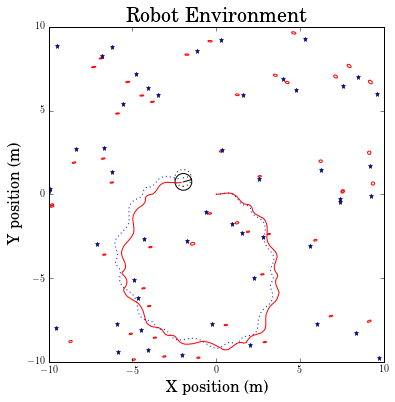

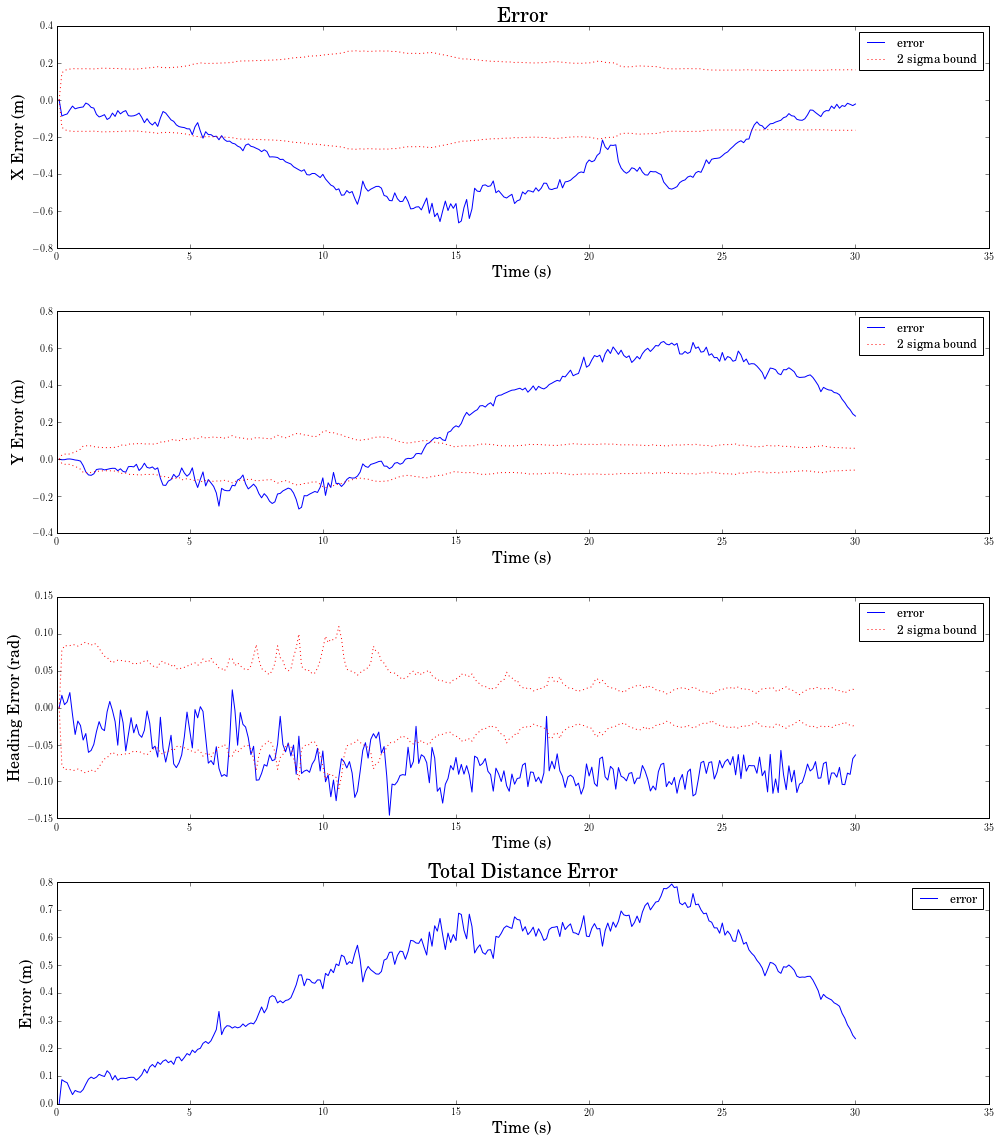

In [8]:
fig = plt.figure(figsize=(14,16))
fig.clear()

ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(t, x[0, :] - xHat[0, :])
ax1.plot(t, 2*sig[0, :], 'r:')
ax1.plot(t, -2*sig[0, :], 'r:')
ax1.set_title("Error",fontsize=20)
ax1.legend(["error", "2 sigma bound"])
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("X Error (m)", fontsize=16)
# ax1.set_ylim([-0.5, 0.5])

ax1 = fig.add_subplot(4, 1, 2)
ax1.plot(t, x[1, :] - xHat[1, :])
ax1.plot(t, 2*sig[1, :], 'r:')
ax1.plot(t, -2*sig[1, :], 'r:')
#ax1.set_title("Error",fontsize=20)
ax1.legend(["error", "2 sigma bound"])
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("Y Error (m)", fontsize=16)
# ax1.set_ylim([-0.5, 0.5])

ax1 = fig.add_subplot(4, 1, 3)
ax1.plot(t, x[2, :] - xHat[2, :])
ax1.plot(t, 2*sig[2, :], 'r:')
ax1.plot(t, -2*sig[2, :], 'r:')
#ax1.set_title("Error",fontsize=20)
ax1.legend(["error", "2 sigma bound"])
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("Heading Error (rad)", fontsize=16)
# ax1.set_ylim([-0.2, 0.2])

ax1 = fig.add_subplot(4, 1, 4)
e = np.sqrt(((x[0, :] - xHat[0, :])**2 + (x[1, :] - xHat[1, :])**2))
ax1.plot(t, e)
ax1.set_title("Total Distance Error",fontsize=20)
ax1.legend(["error"])
ax1.set_xlabel("Time (s)", fontsize=16)
ax1.set_ylabel("Error (m)", fontsize=16)

print("Error norm = {}".format(np.linalg.norm(e)))

plt.tight_layout()
plt.show()

## Questions

* Q: How does the the system behave with poor initial conditions?
* A: The system converges within a few time steps, even with very poor initial conditions.

* Q: How does the system behave with changes in process/noise convariances?
* A: Increasing measurement noise increases estimation error and decreases the Kalman gains. Increasing process noise increases noise in truth, but marginally decreases estimation error. 

* Q: What happens to the quality of your estimates if you reduce the number of landmarks? increase?
* A: Fewer landmarks degrades the estimate. More landmarks marginally improves the localization unless the robot gets too close to a landmark, then it can cause it to diverge.

In [11]:
from tqdm import trange

Ts = 1
Tend = 20

t = np.arange(start=Ts, stop=Tend+Ts, step = Ts)

alpha = np.array([0.1, 0.01, 0.01, 0.1])

v_c = 1 + 0.5*np.cos(2*np.pi*0.2*t)
omega_c = -0.2 + 2*np.cos(2*np.pi*0.6*t)

v = v_c + np.random.normal(0, alpha[0]*np.square(v_c) + alpha[1]*np.square(omega_c))
omega = omega_c + np.random.normal(0, alpha[2]*np.square(v_c) + alpha[3]*np.square(omega_c))

u_c = np.vstack((v_c, omega_c))
u = np.vstack((v, omega))
# print(u.shape)
x = np.zeros((3, len(t)))
x[:, 0] = np.array([-5, -3, np.pi/2])

N = 100
e = np.zeros(N)
for j in trange(N):
    # generate truth data
    for i in xrange(1, len(t)):
        x[:, i] = f(x[:, i-1], u[:, i], Ts)


    xHat = np.zeros_like(x)
    xHat[:, 0] = x[:, 0]
    sig = np.zeros_like(x)
    sig[:, 0] = np.sqrt(P.diagonal())
    K = np.zeros((3, 2, len(t)-1))
    input_dim = u.shape[0]
    ekf = EKF(xHat[:, 0], input_dim, f, g, del_f_x, del_g_x, R, P, Ts, del_f_u=del_f_u, Qu=Qu)

    zHat = np.zeros((2, len(t)))

    for i in xrange(1, len(t)):
        uHat = u[:, i] + np.random.multivariate_normal([0, 0], Qu(u[:, i]))
        ekf.predict(uHat)
        for landmark in landmarks.T:
            z = g(x[:, i], landmark) + np.random.multivariate_normal([0, 0], R)
        #     zdeg = z - x[2, i]
        #     zdeg[1] = zdeg[1]*180/np.pi
        #     print(zdeg)
            zHat[:, i] = z
            ekf.update(z, landmark)
    #     landmark = landmarks[:, 0]
    #     z = g(x[:, i], landmark) + np.random.multivariate_normal([0, 0], R)
    #     ekf.update(z, landmark)
        xHat[:, i] = ekf.x
        K[:, :, i-1] = ekf.K
        sig[:, i] = np.sqrt(ekf.P.diagonal())


    e[j] = np.linalg.norm(np.sqrt(((x[0, :] - xHat[0, :])**2 + (x[1, :] - xHat[1, :])**2)))

print("Over {} runs:".format(N))
print("Mean error norm = {}".format(np.mean(e*Ts)))
print("Standard deviation of error norm = {}".format(np.std(e*Ts)))
    

100%|██████████| 100/100 [00:01<00:00, 72.99it/s]

Over 100 runs:
Mean error norm = 1.2002533331
Standard deviation of error norm = 0.333717604251


In [23]:
1/6.66

0.15015015015015015